In this notebook I'll compare the levels of NO2 in the period during lockdown between the years 2020 and 2019.

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
import statsmodels.api as sm

from warnings import filterwarnings
filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose

from covid19_pollution_func import * #Custom functions

In [2]:
pollutant = 'NO2'

In [3]:
lockdown = dt.datetime(2020,3,14)

In [4]:
df20 = pd.read_csv('../clean_datasets/%s-2020.csv'%(pollutant), index_col=0, parse_dates=True)
df19 = pd.read_csv('../clean_datasets/%s-2019.csv'%(pollutant), index_col=0, parse_dates=True)

In [5]:
df_aft20 = df20.loc[lockdown:,:]
df_aft19 = df19.loc[dt.datetime(2019,lockdown.month, lockdown.day):,:]

In [6]:
#To avoid date issues, I'll change the year of df_aft19 to 2020
df_aft19['old_id'] = df_aft19.index
df_aft19['new_id'] = df_aft19['old_id'].apply(lambda x:dt.datetime(2020, x.month, x.day, x.hour))
df_aft19.set_index('new_id', inplace=True)
df_aft19.drop(columns=['old_id'],inplace=True)
df_aft19.index.rename('dt', inplace=True)

I'll be working with the average concentration throughout all stations per hour.

In [7]:
df_aft20 = df_aft20.groupby('dt')['concentracion'].mean()
df_aft20 = pd.DataFrame(df_aft20)

df_aft19 = df_aft19.groupby('dt')['concentracion'].mean()
df_aft19 = pd.DataFrame(df_aft19)

## Time series plots

In [8]:
tick_pos, tick_labels = half_month_ticks()
#This notebook only has data after march 14

tick_pos = tick_pos[-4:]
tick_labels = tick_labels[-4:]

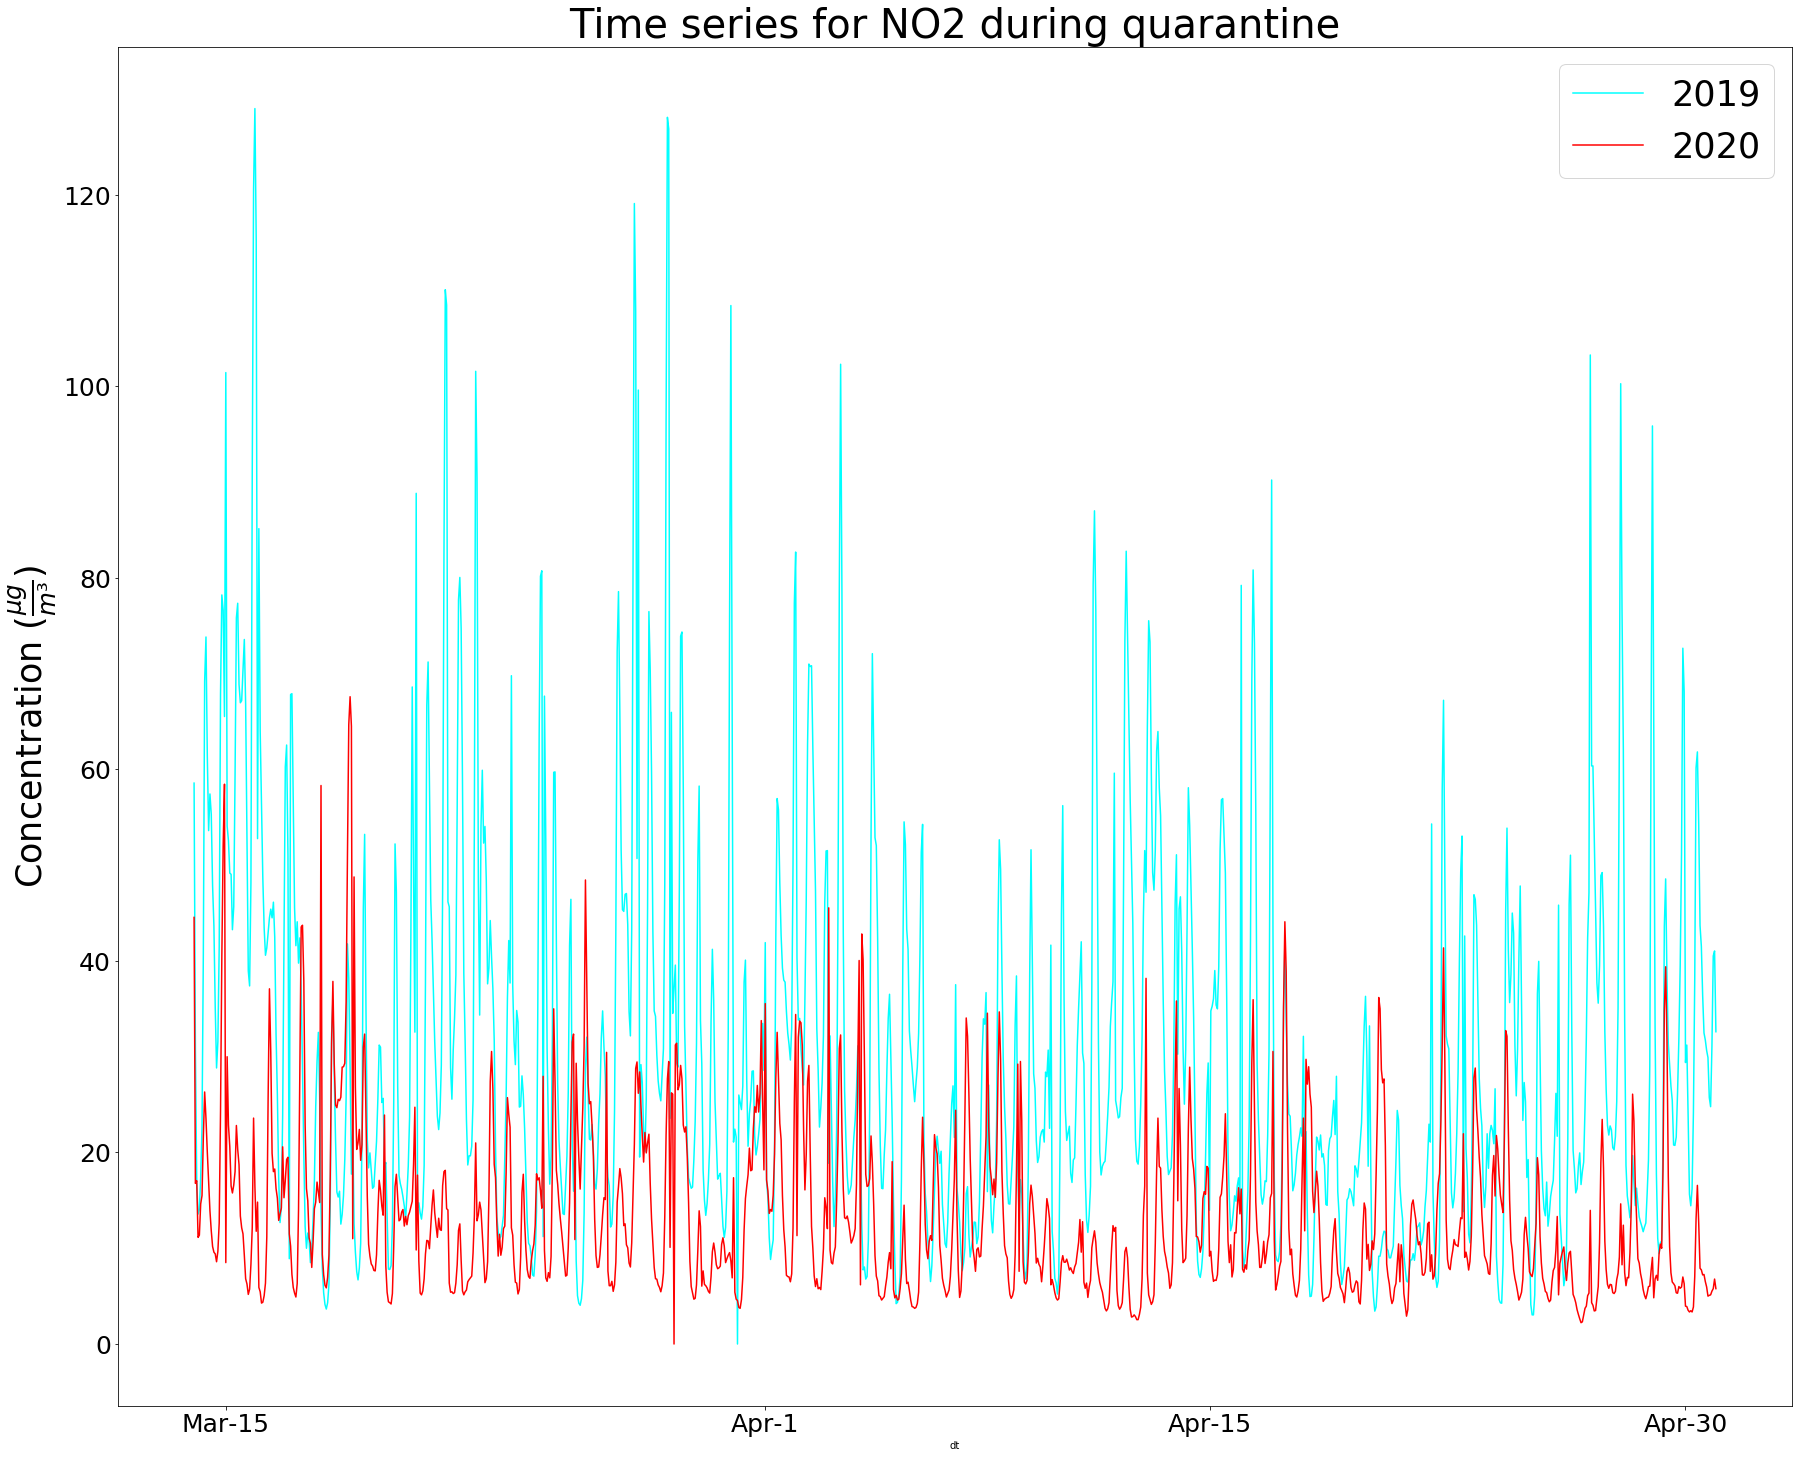

In [9]:
plt.figure(figsize=(30,25))
sns.lineplot(df_aft19.index, df_aft19['concentracion'], label='2019', color='cyan')
sns.lineplot(df_aft20.index, df_aft20['concentracion'], label='2020', color='red')
plt.ylabel(r'Concentration $(\frac{\mu g}{m³})$', fontsize=35)
plt.xticks(ticks=tick_pos, labels=tick_labels, fontsize=25)
plt.yticks(fontsize=25)
plt.title('Time series for ' + pollutant + ' during quarantine', fontsize=40)
plt.legend(fontsize=35);

In [10]:
df_aft19['SMA'] = df_aft19.loc[:,'concentracion'].rolling(window = 24,
                                                min_periods = 1).mean()
df_aft20['SMA'] = df_aft20.loc[:,'concentracion'].rolling(window = 24,
                                                min_periods = 1).mean()

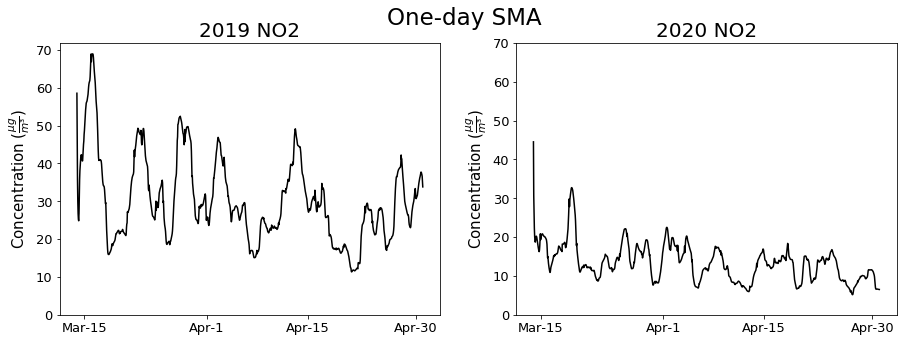

In [11]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle('One-day SMA', fontsize=23)

ax[0].plot(df_aft19.index, df_aft19['SMA'], color='black')
ax[0].set_title('2019 ' + pollutant, fontsize=20)

ax[1].plot(df_aft20.index, df_aft20['SMA'], color='black')
ax[1].set_title('2020 ' + pollutant, fontsize=20)

for i in range(2):
    ax[i].set_xticks(tick_pos)
    ax[i].set_xticklabels(tick_labels, fontsize=13)
    ax[i].set_yticks(list(range(0,71,10)))
    ax[i].set_yticklabels(list(range(0,71,10)), fontsize=13)
    ax[i].set_ylabel(r'Concentration $(\frac{\mu g}{m³})$', fontsize=15)

The data for 2020 is visibly lower and has less variance than that for the same period in 2019. The trend for 2020 appears to be decreasing, while for 2019 it remains more or less stationary.

**Trend and seasonality**

In [19]:
res19 = seasonal_decompose(df_aft19['concentracion'])
res20 = seasonal_decompose(df_aft20['concentracion'])

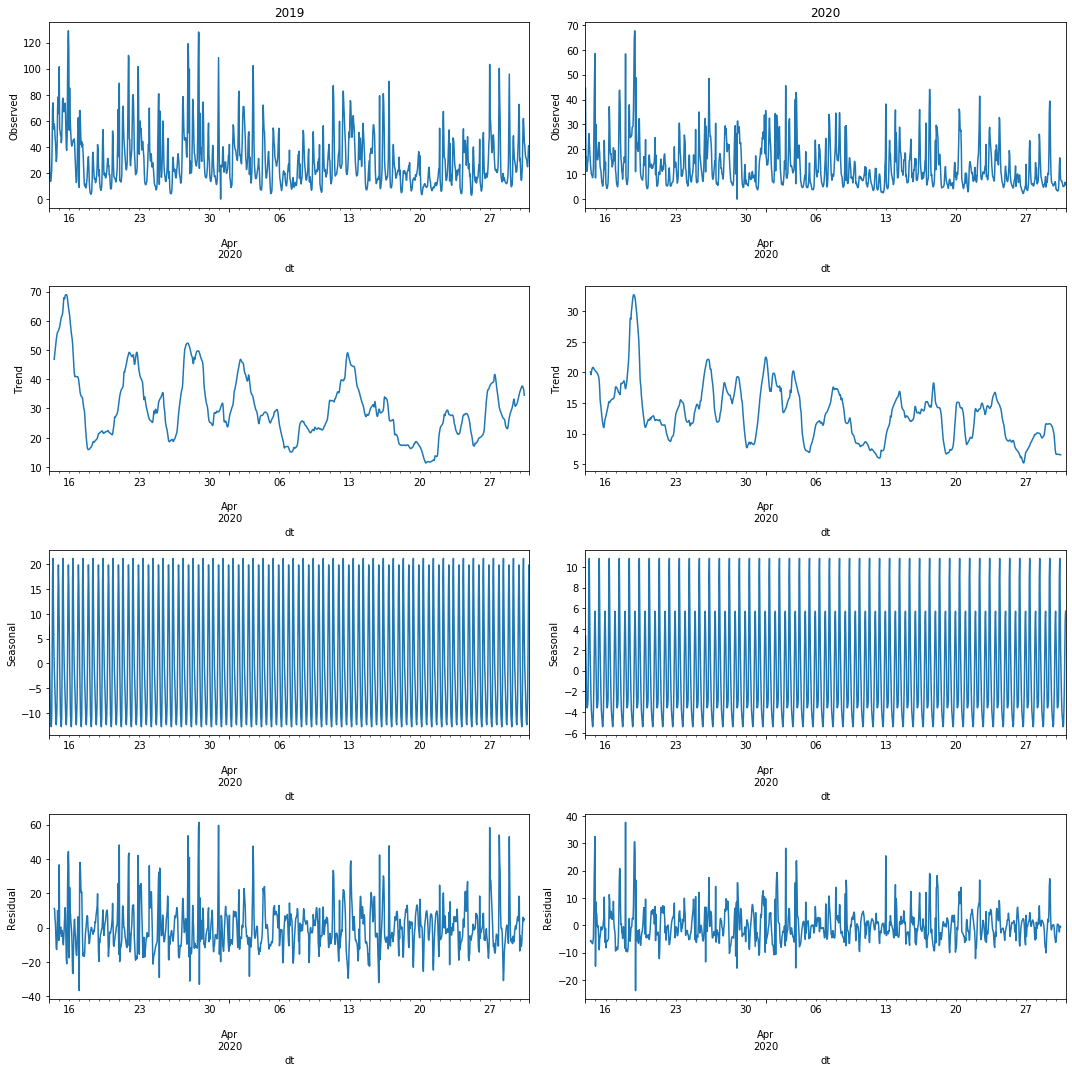

In [16]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize = (15,15))
axes[:,0] = seasonal_plot(res19, axes[:,0], '2019')
axes[:,1] = seasonal_plot(res20, axes[:,1], '2020')
plt.tight_layout()
plt.show()

The behavior is similar across both years but in 2020 the values in each graph are smaller. Of note is that the daily periodicity is mantained in quarantine, just, again, with smaller concentrations of pollutants.

## Summary statistics and histograms

In [12]:
summ_stats_compare(df_aft19['concentracion'], df_aft20['concentracion'], '2019',
                  '2020')

,2019,2020
count,1152.00,1152.00
mean,30.42,13.32
std,20.68,9.05
min,0.00,0.00
25%,15.90,6.86
50%,24.41,10.36
75%,40.80,17.10
max,129.00,67.59
skew,1.49,1.81
kurtosis,2.71,4.71


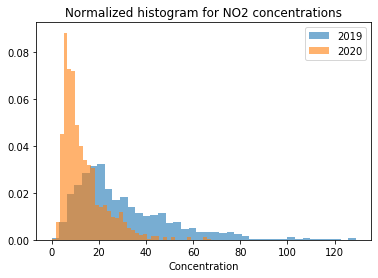

In [13]:
plt.hist(df_aft19['concentracion'].values, bins=40, density=True, 
         label='2019', alpha=0.6)
plt.hist(df_aft20['concentracion'].values, bins=40, density=True,
         label='2020', alpha=0.6)
plt.xlabel('Concentration')
plt.title('Normalized histogram for %s concentrations'%(pollutant))
plt.legend();

A similar scenario to the before-after comparison can be seen here, where the 2020 values have lower variance and thus pool together around smaller values instead of being more spread out.

## Mean and median comparison

In [14]:
stats_mo_19 = df_aft19.groupby(df_aft19.index.month)['concentracion'].describe()
stats_mo_20 = df_aft20.groupby(df_aft20.index.month)['concentracion'].describe()

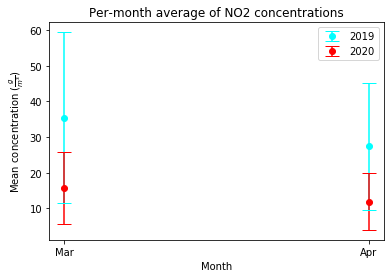

In [15]:
plt.errorbar(stats_mo_19.index, stats_mo_19['mean'], yerr=stats_mo_19['std'], 
             fmt = 'o', label='2019', color='cyan', capsize=7)
plt.errorbar(stats_mo_20.index, stats_mo_20['mean'], yerr=stats_mo_20['std'], 
             fmt = 'o', label='2020', color='red', capsize=7)
plt.title('Per-month average of %s concentrations'%(pollutant))
plt.xlabel('Month')
plt.ylabel(r'Mean concentration $(\frac{g}{m³})$')
plt.xticks(ticks=list(range(3,5)), labels=['Mar','Apr'])
plt.legend(fontsize=10);

In [16]:
#For the boxplot it's necessary to have a column with the months
df_aft19['mes'] = df_aft19.index.month
df_aft20['mes'] = df_aft20.index.month

#Defining label column
month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr'}
df_aft19['mes_nombre'] = df_aft19['mes'].apply(lambda x: month_map[x])
df_aft20['mes_nombre'] = df_aft20['mes'].apply(lambda x: month_map[x])

In [17]:
df_aft19['year'] = 2019
df_aft20['year'] = 2020
df_both = pd.concat([df_aft19, df_aft20])

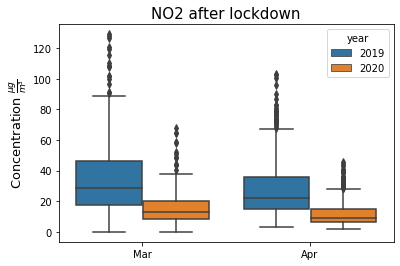

In [18]:
sns.boxplot(x='mes_nombre', y='concentracion', data=df_both, hue='year')
plt.title('%s after lockdown'%(pollutant), fontsize=15)
plt.ylabel(r'Concentration $\frac{\mu g}{m³}$', fontsize=13)
plt.xlabel('');

In [19]:
stats_mo_19['mean'] - stats_mo_20['mean']

dt
3    19.813323
4    15.473510
Name: mean, dtype: float64

## Statistical test for mean difference

It's important to remember that in March only days 1-14 are considered, and that there are some missing values in 2019.

Unlike what happened in the two-year comparison for the period before quarantine, here the median value for 2020 in both months is outside the IQR of 2019, and the IQRs overlap only during March. I'll compare mean values next.

First, I'll check the variances.

In [20]:
stats19 = df_aft19['concentracion'].describe()
stats20 = df_aft20['concentracion'].describe()

In [21]:
np.abs(stats19['std'] - stats20['std'])

11.631368563508836

As could be seen from the above graphs, the difference between the two variances is too great for them to be considered equal, so a Welch t-test will be applied to the difference of the means. First I have to see if the distributions are normal.

In [22]:
df_aft19['conc_norm'] = (df_aft19['concentracion'] - df_aft19['concentracion'].mean())/df_aft19['concentracion'].std()

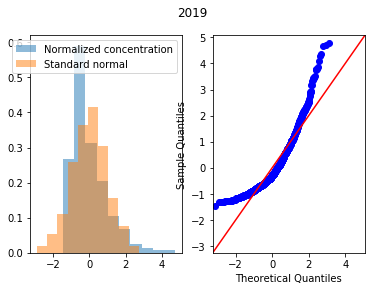

In [23]:
fig, ax = plt.subplots(1,2)
ax[0].hist(df_aft19['conc_norm'].values, density=True, 
           alpha=0.5, label='Normalized concentration')
ax[0].hist(np.random.randn(len(df_aft19)), density=True,
           alpha=0.5, label='Standard normal')
ax[0].legend()
sm.qqplot(df_aft19['conc_norm'], line='45', ax=ax[1])
fig.suptitle('2019');

In [24]:
df_aft20['conc_norm'] = (df_aft20['concentracion'] - df_aft20['concentracion'].mean())/df_aft20['concentracion'].std()

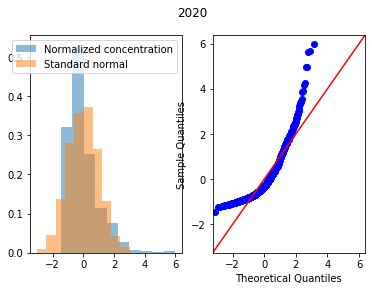

In [25]:
fig, ax = plt.subplots(1,2)
ax[0].hist(df_aft20['conc_norm'].values, density=True, 
           alpha=0.5, label='Normalized concentration')
ax[0].hist(np.random.randn(len(df_aft20)), density=True,
           alpha=0.5, label='Standard normal')
ax[0].legend()
sm.qqplot(df_aft20['conc_norm'], line='45', ax=ax[1])
fig.suptitle('2020');

In [26]:
from scipy import stats

In [27]:
stats.shapiro(df_aft19['conc_norm'])

(0.8783564567565918, 4.4444285094307674e-29)

In [28]:
stats.shapiro(df_aft20['conc_norm'])

(0.840019702911377, 1.6708154911009457e-32)

They're normal enough. The Welch's t-test.

In [29]:
stats.ttest_ind(df_aft19['concentracion'].values, df_aft20['concentracion'].values)

Ttest_indResult(statistic=25.70814392185328, pvalue=2.40699566300237e-128)

In [30]:
print('The difference in overall mean is:', round(stats19['mean'] - stats20['mean'], 2))

The difference in overall mean is: 17.1


To a statistically significant level (p < 0.05), the two means are unequal. Actually, the p-value is so tiny that it's practically zero.

## Autocorrelation and seasonality

I'll compare autocorrelations to check trends.

In [31]:
autocorr19 = [df_aft19['concentracion'].autocorr(tau) for tau in range(len(df_aft19))]
autocorr20 = [df_aft20['concentracion'].autocorr(tau) for tau in range(len(df_aft20))]

In [32]:
df_autocorr = pd.DataFrame({19:autocorr19, 20:autocorr20})
df_autocorr.describe()

,19,20
count,1151.000000,1151.000000
mean,0.002727,0.031608
std,0.227110,0.180368
min,-0.847634,-0.707306
25%,-0.173647,-0.100137
50%,-0.017155,0.019655
75%,0.173841,0.145012
max,1.000000,1.000000


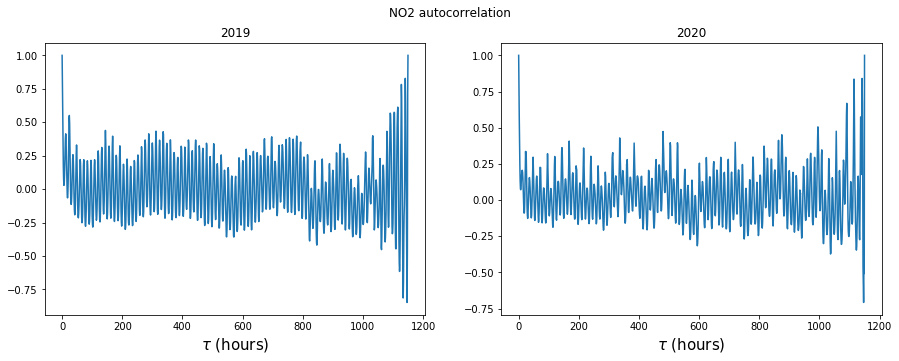

In [33]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle(pollutant + ' autocorrelation')

ax[0].plot(range(len(autocorr19)), autocorr19)
ax[0].set_title('2019')

ax[1].plot(range(len(autocorr20)), autocorr20)
ax[1].set_title('2020')

for i in range(2):
    ax[i].set_xlabel(r'$\tau$ (hours)', fontsize=15)

#plt.ylabel(r'ACF($\tau$)', fontsize=15)

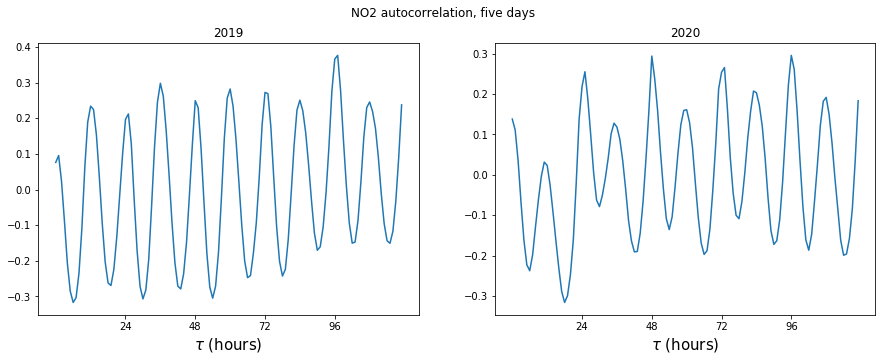

In [34]:
five_days = 24*5
half_point = len(autocorr19)//2
x19 = range(len(autocorr19[half_point:half_point+five_days])) #x coords for 2019
y19 = autocorr19[half_point:half_point+five_days]
x20 = range(len(autocorr20[half_point:half_point+five_days])) #x coords for 2020
y20 = autocorr20[half_point:half_point+five_days]

fig, ax = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle(pollutant + ' autocorrelation, five days')

ax[0].plot(x19, y19)
ax[0].set_title('2019')

ax[1].plot(x20, y20)
ax[1].set_title('2020')

for i in range(2):
    ax[i].set_xlabel(r'$\tau$ (hours)', fontsize=15)
    ax[i].set_xticks(list(range(24, 120, 24)))

The autocorrelation values are very similar across both 2019 and 2020, except that 2020 has a more uniform behavior (lower standard deviation, as had been seen before in the histograms). The daily seasonality is not lost, meaning that the main sources of the pollutant where not abandoned to the point where this behavior was lost between the noise.

## Poincaré Diagram

In [35]:
#Calculating the correlation coefficient between x_n and x_{n+1}
df_aft19['concentracion_shift'] = df_aft19['concentracion'].shift(1)
df_aft19[['concentracion','concentracion_shift']].corr()

,concentracion,concentracion_shift
concentracion,1.000000,0.789041
concentracion_shift,0.789041,1.000000


In [36]:
#Performing a linear regression
model = sm.OLS.from_formula('concentracion_shift ~ concentracion', data = df_aft19)
linear_reg = model.fit()
b0_19, b1_19 = linear_reg.params
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     concentracion_shift   R-squared:                       0.623
Model:                             OLS   Adj. R-squared:                  0.622
Method:                  Least Squares   F-statistic:                     1895.
Date:                 Tue, 19 May 2020   Prob (F-statistic):          2.27e-245
Time:                         14:55:28   Log-Likelihood:                -4559.2
No. Observations:                 1151   AIC:                             9122.
Df Residuals:                     1149   BIC:                             9132.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.4165      0.667      9.623      0.000       5.108       7.725
concentracion     0.7897      0.018     43.536      0.000       0.754       0.825
==============================================================================
Omnibus:                      482.419   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5074.144
Skew:                           1.638   Prob(JB):                         0.00
Kurtosis:                      12.750   Cond. No.                         65.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---

In [37]:
df_aft20['concentracion_shift'] = df_aft20['concentracion'].shift(1)
df_aft20[['concentracion','concentracion_shift']].corr()

,concentracion,concentracion_shift
concentracion,1.000000,0.743114
concentracion_shift,0.743114,1.000000


In [38]:
model = sm.OLS.from_formula('concentracion_shift ~ concentracion', data = df_aft20)
linear_reg = model.fit()
b0_20, b1_20 = linear_reg.params
linear_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     concentracion_shift   R-squared:                       0.552
Model:                             OLS   Adj. R-squared:                  0.552
Method:                  Least Squares   F-statistic:                     1417.
Date:                 Tue, 19 May 2020   Prob (F-statistic):          1.09e-202
Time:                         14:55:28   Log-Likelihood:                -3706.1
No. Observations:                 1151   AIC:                             7416.
Df Residuals:                     1149   BIC:                             7426.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.4008      0.319     10.675      0.000       2.776       4.026
concentracion     0.7468      0.020     37.643      0.000       0.708       0.786
==============================================================================
Omnibus:                      639.542   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14273.962
Skew:                           2.090   Prob(JB):                         0.00
Kurtosis:                      19.738   Cond. No.                         28.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

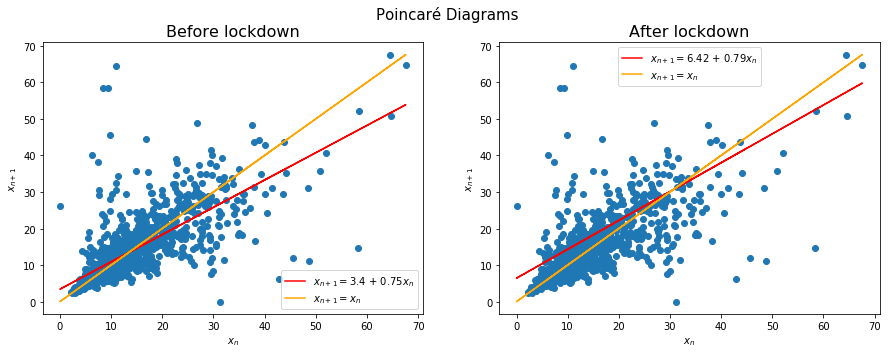

In [39]:
str_b0_19, str_b1_19 = str(round(b0_19,2)), str(round(b1_19,2))
str_b0_20, str_b1_20 = str(round(b0_20,2)), str(round(b1_20,2))

fig, ax = plt.subplots(1,2, figsize = (15, 5))
fig.suptitle('Poincaré Diagrams', fontsize=15)

#Line obtained above
ax[0].scatter(df_aft20['concentracion'],df_aft20['concentracion_shift'])
ax[0].plot(df_aft20['concentracion'], b0_20 + b1_20*df_aft20['concentracion'], color = 'red',
             label = r'$x_{n + 1} = $' + str_b0_20 + ' + ' + str_b1_20 + r'$x_n$')
#Identity line
ax[0].plot(df_aft20['concentracion'], df_aft20['concentracion'], 
             color='orange', label=r'$x_{n + 1} = x_n$')
ax[0].set_title('Before lockdown', fontsize=16)
ax[0].legend()


#Line obtained above
ax[1].scatter(df_aft20['concentracion'],df_aft20['concentracion_shift'])
ax[1].plot(df_aft20['concentracion'], b0_19 + b1_19*df_aft20['concentracion'], color = 'red',
             label = r'$x_{n + 1} = $' + str_b0_19 + ' + ' + str_b1_19 + r'$x_n$')
#Identity line
ax[1].plot(df_aft20['concentracion'], df_aft20['concentracion'], 
             color='orange', label=r'$x_{n + 1} = x_n$')

ax[1].set_title('After lockdown', fontsize=16)
ax[1].legend()

for i in range(2):
    ax[i].set_xlabel(r'$x_n$')
    ax[i].set_ylabel(r'$x_{n + 1}$')

There's actually not that big a difference here, surprisingly.

In conclusion, for NO2 there is a noticeable (and statistically significant) difference in the levels of pollutant concentration in Madrid between the period of quarantine in 2020 and the equivalent period in 2019. The actual behavior of the pollutant, however, remained largely the same in its seasonality and determinism, but during 2020 the distribution of values was much tighter around smaller values and the trend was seen to be decreasing. In 2019 the distribution was more spread out and the trend was visibly stationary.